# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
print(data.columns.values)

['number_of_elements' 'mean_atomic_mass' 'wtd_mean_atomic_mass'
 'gmean_atomic_mass' 'wtd_gmean_atomic_mass' 'entropy_atomic_mass'
 'wtd_entropy_atomic_mass' 'range_atomic_mass' 'wtd_range_atomic_mass'
 'std_atomic_mass' 'wtd_std_atomic_mass' 'mean_fie' 'wtd_mean_fie'
 'gmean_fie' 'wtd_gmean_fie' 'entropy_fie' 'wtd_entropy_fie' 'range_fie'
 'wtd_range_fie' 'std_fie' 'wtd_std_fie' 'mean_atomic_radius'
 'wtd_mean_atomic_radius' 'gmean_atomic_radius' 'wtd_gmean_atomic_radius'
 'entropy_atomic_radius' 'wtd_entropy_atomic_radius' 'range_atomic_radius'
 'wtd_range_atomic_radius' 'std_atomic_radius' 'wtd_std_atomic_radius'
 'mean_Density' 'wtd_mean_Density' 'gmean_Density' 'wtd_gmean_Density'
 'entropy_Density' 'wtd_entropy_Density' 'range_Density'
 'wtd_range_Density' 'std_Density' 'wtd_std_Density'
 'mean_ElectronAffinity' 'wtd_mean_ElectronAffinity'
 'gmean_ElectronAffinity' 'wtd_gmean_ElectronAffinity'
 'entropy_ElectronAffinity' 'wtd_entropy_ElectronAffinity'
 'range_ElectronAffinity' 'w

In [7]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.

In [4]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [5]:
X_data = data.loc[:, data.columns != "critical_temp"]
Y_data = data.loc[:, data.columns == "critical_temp"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [6]:
#Data normalisation
X_data = scale(X_data)
Y_data = scale(Y_data)

In [7]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")


# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  2126
There is 10 devices.
torch.Size([2126, 82])


In [8]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

Large dimension...
   it    |   obj   
    4000 | 2.7702e-01
    8000 | 2.7102e-01
   12000 | 2.6850e-01
   16000 | 2.6717e-01


100%|██████████| 1/1 [09:45<00:00, 585.13s/it]

Gradient Descent: execution time=585.025 seconds
Final loss :  0.266367082297802

CPU times: user 44min 15s, sys: 14min 14s, total: 58min 29s
Wall time: 9min 45s


Text(0.5, 0, 'true value (normalized)')

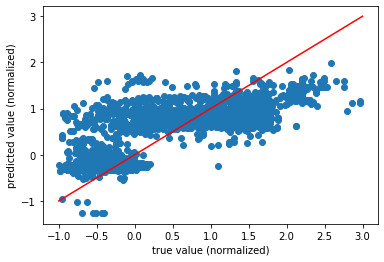

In [9]:
plt.scatter(Y[0], X[0].mv(obj_min_by_N_descent.model_params[-1]))
plt.plot(np.linspace(-1, 3, 2), np.linspace(-1, 3, 2), color='r')
plt.ylabel("predicted value (normalized)")
plt.xlabel("true value (normalized)")

In [10]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = RMSEModel(), 
                                               use_averaging=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 20%|██        | 1/5 [02:56<11:44, 176.02s/it]

QSGD
Large dimension...
Large dimension...


 40%|████      | 2/5 [10:32<13:00, 260.31s/it]

Diana
Large dimension...
Large dimension...


 60%|██████    | 3/5 [18:07<10:36, 318.46s/it]

BiQSGD
Large dimension...
Large dimension...


 80%|████████  | 4/5 [26:08<06:07, 367.39s/it]

Artemis
Large dimension...
Large dimension...


100%|██████████| 5/5 [34:14<00:00, 410.84s/it]

CPU times: user 46min 3s, sys: 1min 36s, total: 47min 40s
Wall time: 34min 14s


In [11]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

SGD model, the first value corresponds to the bias: 
tensor([ 1.7458e-04,  5.9036e-02,  5.2739e-02, -6.3471e-03,  2.2511e-02,
         3.2425e-02, -6.5198e-02,  1.4546e-01,  1.7669e-01, -7.4461e-02,
         8.7938e-02, -1.1313e-01,  3.6940e-02, -8.1424e-03,  5.5526e-02,
         2.2185e-03,  7.4825e-03,  8.0236e-03,  7.1852e-02,  1.7989e-02,
        -6.2362e-02, -5.9404e-02,  1.4061e-02,  1.1217e-01, -4.9293e-02,
         3.2574e-02, -5.9672e-03,  1.0191e-01,  1.5266e-01, -9.5546e-02,
         1.0353e-02,  7.4312e-02, -7.8322e-02, -1.1910e-02, -6.8124e-02,
         2.6377e-03, -4.1649e-02, -9.8161e-02, -1.8975e-02,  9.5057e-02,
        -1.0101e-02, -7.9625e-02,  6.7526e-02,  4.9993e-02,  6.6325e-04,
        -1.3760e-01, -9.6673e-02, -1.8283e-01, -8.9676e-02, -9.6471e-02,
         7.1720e-02, -1.7752e-02,  3.4573e-02,  2.7004e-03, -1.2649e-02,
         1.0131e-03,  4.6901e-03,  1.1737e-01, -3.4778e-02,  4.3744e-02,
         2.4880e-03, -8.2123e-02,  6.1896e-02,  2.2642e-01, -6.4565e-02

In [12]:
res.all_losses

[[array([1.10008092, 0.35595866, 0.33872317, 0.32991646, 0.32436797,
         0.32048011, 0.31757182, 0.31529674, 0.3134577 , 0.31193322,
         0.3106439 , 0.30953545, 0.30856938, 0.30771759, 0.30695907,
         0.30627772, 0.30566103, 0.30509911, 0.30458405, 0.30410938,
         0.30366985, 0.30326107, 0.3028794 , 0.30252174, 0.3021855 ,
         0.30186842, 0.3015686 , 0.30128435, 0.30101424, 0.30075701,
         0.30051154, 0.30027685, 0.30005206, 0.29983642, 0.29962922,
         0.29942985, 0.29923776, 0.29905243, 0.29887344, 0.29870035]),
  array([1.10008092, 0.35595866, 0.33872317, 0.32991646, 0.32436797,
         0.32048011, 0.31757182, 0.31529674, 0.3134577 , 0.31193322,
         0.3106439 , 0.30953545, 0.30856938, 0.30771759, 0.30695907,
         0.30627772, 0.30566103, 0.30509911, 0.30458405, 0.30410938,
         0.30366985, 0.30326107, 0.3028794 , 0.30252174, 0.3021855 ,
         0.30186842, 0.3015686 , 0.30128435, 0.30101424, 0.30075701,
         0.30051154, 0.30027685,

## With averaging

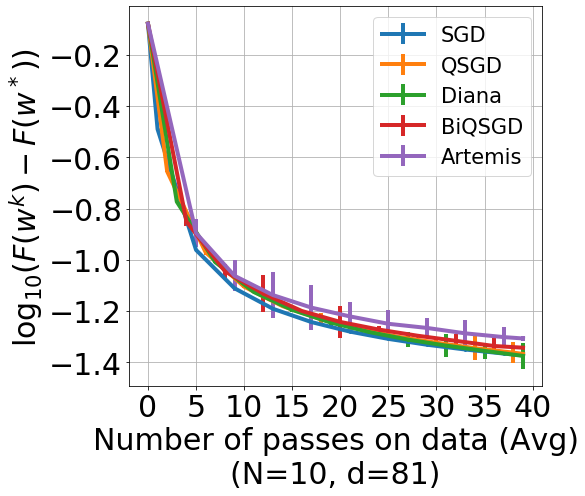

In [13]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

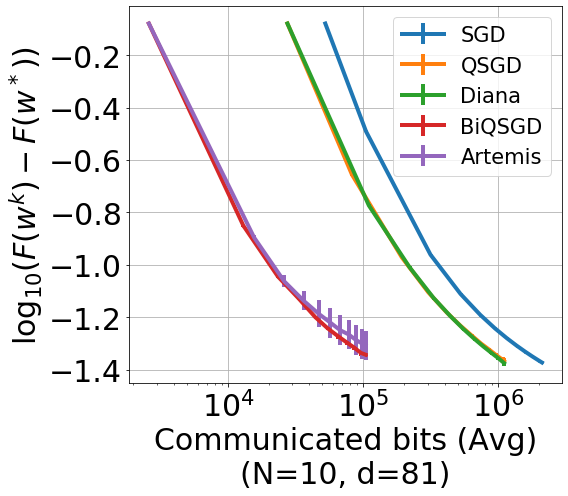

In [14]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

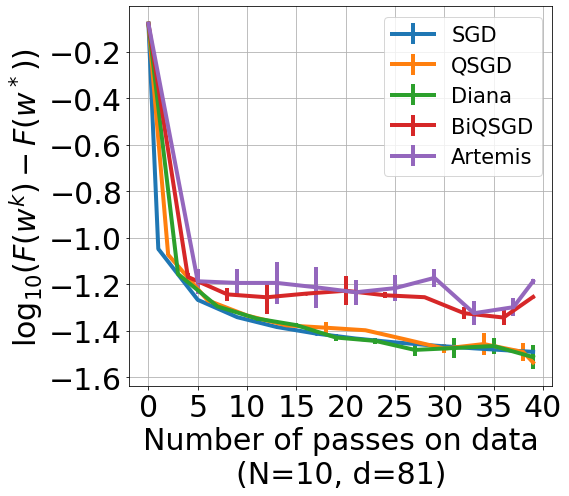

In [15]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

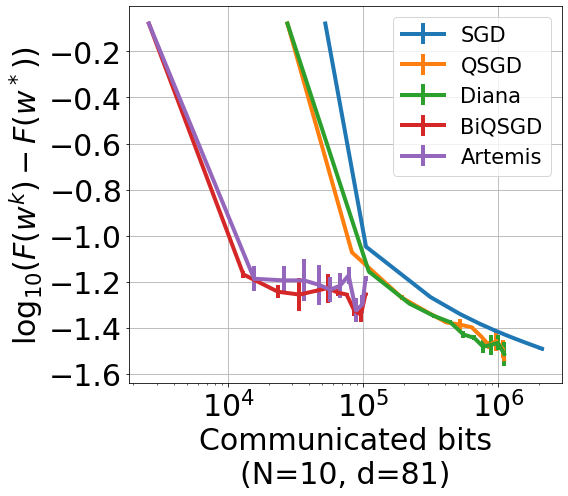

In [16]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

# With Polynomial Features

In [17]:
# With Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_data)
print("The number of variables is now : ", X_poly.shape[1])
dim_poly = X_poly.shape[1]

The number of variables is now :  3403


In [18]:
X_merged = torch.tensor(X_poly, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  2126
There is 10 devices.
torch.Size([2126, 3404])


In [19]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_poly + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=2000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

Large dimension...
   it    |   obj   
     400 | 2.7242e-01
     800 | 2.4373e-01
    1200 | 2.3111e-01
    1600 | 2.2348e-01


100%|██████████| 1/1 [09:43<00:00, 583.22s/it]

Gradient Descent: execution time=577.205 seconds
Final loss :  0.21814509816467761

CPU times: user 1h 23min 58s, sys: 24min 22s, total: 1h 48min 21s
Wall time: 9min 43s


Text(0.5, 0, 'true value (normalized)')

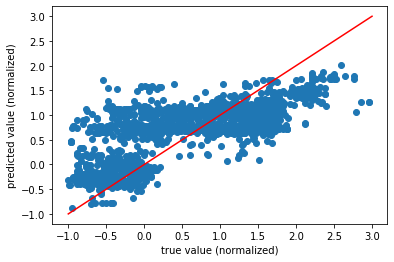

In [20]:
plt.scatter(Y[0], X[0].mv(obj_min_by_N_descent.model_params[-1]))
plt.plot(np.linspace(-1, 3, 2), np.linspace(-1, 3, 2), color='r')
plt.ylabel("predicted value (normalized)")
plt.xlabel("true value (normalized)")

In [ ]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = RMSEModel(), 
                                               use_averaging=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

In [ ]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

## With averaging

In [ ]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_poly, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

In [ ]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_poly, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

In [ ]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_poly,
               all_error=res.get_std(obj)) 

In [ ]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_poly, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 